In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate2d, convolve2d # scipy.signal is a signal processing library

## The convolution operation

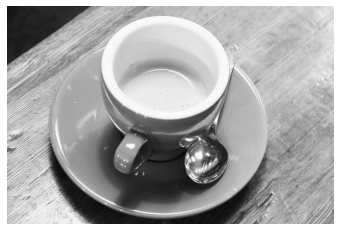

In [2]:
# load an image
from skimage import data
image = data.coffee()[:,:,0]
plt.imshow(image, cmap='gray')
plt.axis(False)
plt.show()

In [3]:
# Kernel for (vertical) edge detection
kernel_y = np.array([[1,0,-1],
                   [2,0,-2,],
                   [1,0,-1]])
kernel_y

array([[ 1,  0, -1],
       [ 2,  0, -2],
       [ 1,  0, -1]])

In [4]:
# Kernel for (horizontal) edge detection
kernel_x = kernel_y.T
kernel_x

array([[ 1,  2,  1],
       [ 0,  0,  0],
       [-1, -2, -1]])

In [5]:
image.shape

(400, 600)

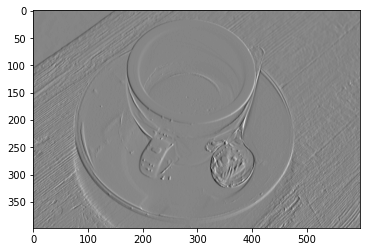

In [9]:
output = correlate2d(image,kernel_y,'valid')
plt.imshow(output, cmap='gray')

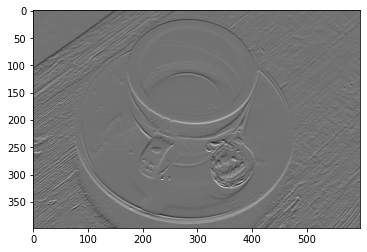

In [10]:
output = correlate2d(image,kernel_x,'valid')
plt.imshow(output, cmap='gray')

The hope: a CNN will find good kernels

## The convolutional layer

In [11]:
class convolutional_layer():
    def __init__(self, input_shape, kernel_size, depth):
        
        # input_shape = (depth, width, height) of each input
        input_depth, input_height, input_width = input_shape
        self.input_shape = input_shape
        self.input_depth = input_depth
        
        
        # depth = number of kernels
        self.depth = depth
        
        # output shape
        self.output_shape = (depth, input_height - kernel_size + 1, input_width - kernel_size + 1)
        
        # initialize kernels (weights) and biases
        self.kernels_shape = (depth, input_depth, kernel_size, kernel_size)
        self.weights = 0.1*np.random.randn(depth, input_depth, kernel_size, kernel_size)
        self.biases = np.zeros(self.output_shape)

        # initialize momentums and caches (for ADAM)
        self.weight_momentums = np.zeros(self.weights.shape)
        self.weight_caches = np.zeros(self.weights.shape)
        self.bias_momentums = np.zeros(self.biases.shape)
        self.bias_caches = np.zeros(self.biases.shape)
        
    def forward(self, inputs):
        
        # save inputs
        self.inputs = inputs
        
        # initialize output array
        self.output = np.copy(self.biases)
        
        # loop over kernels
        for i in range(self.depth):
            for j in range(self.input_depth):
                self.output[i] += correlate2d(self.inputs[j], self.weights[i, j], "valid")
                
    def backward(self, dinputs):

        # initialize gradients
        self.dweights = np.zeros(self.kernels_shape) # weights = kernels Kij
        self.dinputs = np.zeros(self.input_shape)
        self.dbiases = dinputs
        
        for i in range(self.depth):
            for j in range(self.input_depth):
                self.dweights[i, j] = correlate2d(self.inputs[j], dinputs[i], "valid")
                self.dinputs[j] += convolve2d(dinputs[i], self.weights[i, j], "full")

    
    
    
class reshape:
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape

    def forward(self, inputs):
        self.output = np.reshape(inputs, self.output_shape)

    def backward(self, dinputs):
        self.dinputs = np.reshape(dinputs, self.input_shape)
        
# neural network layer
class layer:
    
    # initialization (weights and biases)
    def __init__(self,n_inputs, n_neurons): # self represents the instance of the class
        self.weights = 0.1*np.random.randn(n_inputs,n_neurons) # small random numbers
        self.biases = np.zeros((1,n_neurons))# zeros
        
        # initialize momentums and caches
        self.weight_momentums = np.zeros(self.weights.shape)
        self.weight_caches = np.zeros(self.weights.shape)
        self.bias_momentums = np.zeros(self.biases.shape)
        self.bias_caches = np.zeros(self.biases.shape)
        
    # forward pass: pass the data through the layer
    def forward(self, inputs):
        # we need to store the output
        self.output = inputs.dot(self.weights) + self.biases
        
        # remember input values
        self.inputs = inputs
        
    def backward(self, dinputs):
        
        # gradient
        self.dinputs = dinputs.dot(self.weights.T)
        
        # gradients on parameters
        self.dweights = self.inputs.T.dot(dinputs)
        self.dbiases = np.sum(dinputs, axis=0, keepdims=True)
        

        
# activation function
class ReLU:
    def forward(self, inputs):
        self.output = np.maximum(0, inputs)
        
        # remember input values
        self.inputs = inputs
        
    def backward(self, dinputs):

        # copy dvalues
        self.dinputs = dinputs.copy()
        
        # zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0
        
        

        
# softmax activation function
class softmax:
    
    def forward(self, inputs):
        
        # unnormalized probabilities
        exp_values = np.exp(inputs-np.max(inputs,axis=1, keepdims=True))
        
        # normalized probabilities
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities
        
        # remember input values
        self.inputs = inputs
        
        
    def backward(self,dinputs):

        
        # initialized gradient array
        self.dinputs = np.zeros(dinputs.shape)
        
        # For each data point, compute gradient
        for i in range(len(dinputs)):
            
            # probabilities 
            proba = self.output[i]
            
            # loss gradients
            dinputs_row = dinputs[i]


            # calculate derivative matrix of the output
            derivative_matrix = np.diag(proba) - proba.reshape(-1,1).dot(proba.reshape(1,-1))
            
            # store gradient
            self.dinputs[i] = dinputs_row.dot(derivative_matrix)
            

class loss_crossentropy():
    
    def forward(self, y_hat, y):
        
        # number of data points
        n_samples = len(y)
        
        # clip data to prevent division by 0
        y_hat_clipped = np.clip(y_hat, 1e-7,1 - 1e-7)
        
        # predicted class probabilities
        pred_proba = y_hat_clipped[range(n_samples),y]
       
        # sample losses 
        losses = -np.log(pred_proba)
        
        return losses
    
    
    def backward(self, p, y):
        
        
        # number of samples
        n_samples = len(y)
    
        # one-hot matrix
        Y = np.zeros(p.shape)
        Y[np.arange(len(y)),y] = 1
        
        # calculate gradient
        self.dinputs = -Y / p
        
        # normalized gradient
        self.dinputs = self.dinputs / n_samples
            
            
        
class optimizer_GD:

    def __init__(self, learning_rate=1):
        self.learning_rate = learning_rate
        
    def update_parameters(self, layer):
        
        # apply gradient descent iteration
        layer.weights = layer.weights - self.learning_rate*layer.dweights
        layer.biases = layer.biases - self.learning_rate*layer.dbiases
        
        
# Adam optimizer
class optimizer_ADAM:
    
    # Initialize optimizer - set parameters
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7,beta_1=0.9, beta_2=0.999):
        
        # initial learning rate
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        
        # decay parameters
        self.decay = decay
        
        # number of epochs
        self.epoch = 0
        
        # update learning rate parameter
        self.epsilon = epsilon
        
        # momentum parameter
        self.beta_1 = beta_1
        
        # cache parameter
        self.beta_2 = beta_2
        
        
    # update learning rate
    def pre_update_parameters(self):
        
        # update learning rate
        self.current_learning_rate = self.learning_rate * (1 / (1 + self.decay * self.epoch))
            
    # Update weights/biases
    def update_parameters(self, layer):
                   
        # momentums
        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases
        
        # corrected momentums
        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.epoch + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.epoch + 1))
        
        # cache
        layer.weight_caches = self.beta_2 * layer.weight_caches + (1 - self.beta_2) * layer.dweights**2  
        layer.bias_caches = self.beta_2 * layer.bias_caches + (1 - self.beta_2) * layer.dbiases**2
        
        # corrected cache
        weight_caches_corrected = layer.weight_caches / (1 - self.beta_2 ** (self.epoch + 1))
        bias_caches_corrected = layer.bias_caches / (1 - self.beta_2 ** (self.epoch + 1))
        
        # update weights and biases
        layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_caches_corrected) + self.epsilon)
        layer.biases += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_caches_corrected) + self.epsilon)
        
    # update epoch
    def post_update_parameters(self):
        self.epoch += 1
        
        
# dropout layer
class dropout:
    
    # initialization - set the dropout rate
    def __init__(self, rate):
        self.rate = rate
        
    # forward pass
    def forward(self, inputs):
        # save inputs 
        self.inputs = inputs
        # mask
        self.mask = np.random.binomial(1, 1 - self.rate, size = inputs.shape) / (1 - self.rate)
        # apply mask
        self.output = inputs * self.mask
        
    # backward pass
    def backward(self, dinputs):
        self.dinputs = dinputs*self.mask

## MNIST

In [47]:
import pandas as pd

In [76]:
url = 'https://raw.githubusercontent.com/um-perez-alvaro/Data-Science-Theory/master/Data/digits.csv'
data = pd.read_csv(url)
data.head()

,pixel 0,pixel 1,pixel 2,pixel 3,pixel 4,pixel 5,pixel 6,pixel 7,pixel 8,pixel 9,...,pixel 775,pixel 776,pixel 777,pixel 778,pixel 779,pixel 780,pixel 781,pixel 782,pixel 783,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9


In [77]:
X = data.drop('label',axis=1).to_numpy()
y = data['label'].to_numpy()

In [78]:
X.shape

(5000, 784)

In [79]:
X = X.reshape(len(X),1,28,28)

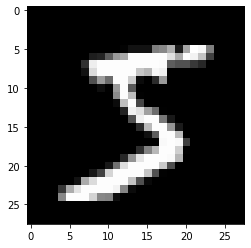

In [80]:
plt.imshow(X[0,0],cmap='gray')

## Convolutional Neural Network

In [81]:
# layer 1
layer1 = convolutional_layer(input_shape=(1,28,28), kernel_size=5, depth=5)
activation1 = ReLU()


# layer 2
layer2 = reshape(input_shape=(5,24,24), output_shape=(1,5*24*24)) # 24 = 28-5+1

# layer 3
layer3 = layer(n_inputs = 5 * 24 * 24, n_neurons = 10)
activation3 = softmax()


# loss function 
loss_function = loss_crossentropy()

# optimizer
optimizer = optimizer_ADAM(learning_rate=0.01)

In [82]:
# warning: CNNs on CPUs are very slow. To speed it up, we need to run this on GPUs
n_epochs = 10
loss = np.zeros(n_epochs)
accuracy = np.zeros(n_epochs)
# gradient descent iterations
for epoch in range(n_epochs):
    
    # EPOCH = loop over all datapoints
    losses = np.zeros(len(X))
    y_pred = np.zeros(len(X))
    for i in range(len(X)):

        # forward pass
        layer1.forward(X[i])
        activation1.forward(layer1.output)

        layer2.forward(activation1.output)
        
        layer3.forward(layer2.output)
        activation3.forward(layer3.output)
        

        # sample loss
        losses[i] = loss_function.forward(activation3.output,y[i].reshape(1))
        # prediction
        y_pred[i] = np.argmax(activation3.output,axis=1)
        

        # backward pass
        loss_function.backward(activation3.output,y[i].reshape(1))
        activation3.backward(loss_function.dinputs)
        layer3.backward(activation3.dinputs)


        layer2.backward(layer3.dinputs)

        activation1.backward(layer2.dinputs)
        layer1.backward(activation1.dinputs)


        # update weights and biases
        optimizer.pre_update_parameters()
        optimizer.update_parameters(layer1)
        optimizer.update_parameters(layer3)
        optimizer.post_update_parameters()

    # loss and accuracy
    loss[epoch] = np.mean(losses)
    accuracy[epoch] = 100*np.mean(y_pred == y)
    
    
    # print loss and accuracy 
    print('epoch: '+str(epoch))
    print('loss: '+str(np.round(loss[epoch],3)))
    print('accuracy: '+str(accuracy[epoch]))
    print('------------------------')

epoch: 0
loss: 0.598
accuracy: 85.48
------------------------
epoch: 1
loss: 0.368
accuracy: 92.75999999999999
------------------------
epoch: 2
loss: 0.308
accuracy: 94.24
------------------------
epoch: 3
loss: 0.248
accuracy: 96.08
------------------------
epoch: 4
loss: 0.264
accuracy: 96.54
------------------------
epoch: 5
loss: 0.189
accuracy: 97.54
------------------------
epoch: 6
loss: 0.166
accuracy: 97.92
------------------------
epoch: 7
loss: 0.16
accuracy: 97.96000000000001
------------------------
epoch: 8
loss: 0.159
accuracy: 98.46000000000001
------------------------
epoch: 9
loss: 0.119
accuracy: 98.6
------------------------


In [110]:
# layer 1
layer1 = convolutional_layer(input_shape=(1,28,28), kernel_size=5, depth=5)
activation1 = ReLU()

# layer 2
layer2 = convolutional_layer(input_shape=(5,24,24), kernel_size=5, depth=5) # 24 = 28-5+1
activation2 = ReLU()

# layer 3
layer3 = reshape(input_shape=(5,20,20), output_shape=(1,5*20*20)) # 20 = 24-5+1

# layer 4
layer4 = layer(n_inputs = 5 * 20 * 20, n_neurons = 10)
activation4 = softmax()


# loss function 
loss_function = loss_crossentropy()

# optimizer
optimizer = optimizer_ADAM(learning_rate=0.01)

In [111]:
# warning: CNNs on CPUs are very slow. To speed it up, we need to run this on GPUs (invented for video grames!)
n_epochs = 10
loss = np.zeros(n_epochs)
accuracy = np.zeros(n_epochs)
# gradient descent iterations
for epoch in range(n_epochs):
    
    # EPOCH = loop over all datapoints
    losses = np.zeros(len(X))
    y_pred = np.zeros(len(X))
    for i in range(len(X)):

        # forward pass
        layer1.forward(X[i])
        activation1.forward(layer1.output)

        layer2.forward(activation1.output)
        activation2.forward(layer2.output)
        
        layer3.forward(activation2.output)
        
        layer4.forward(layer3.output)
        activation4.forward(layer4.output)
        

        # sample loss
        losses[i] = loss_function.forward(activation4.output,y[i].reshape(1))
        # prediction
        y_pred[i] = np.argmax(activation4.output,axis=1)
        

        # backward pass
        loss_function.backward(activation4.output,y[i].reshape(1))
        activation4.backward(loss_function.dinputs)
        layer4.backward(activation4.dinputs)

        layer3.backward(layer4.dinputs)
        
        activation2.backward(layer3.dinputs)
        layer2.backward(activation2.dinputs)

        activation1.backward(layer2.dinputs)
        layer1.backward(activation1.dinputs)


        # update weights and biases
        optimizer.pre_update_parameters()
        optimizer.update_parameters(layer1)
        optimizer.update_parameters(layer2)
        optimizer.update_parameters(layer4)
        optimizer.post_update_parameters()

    # loss and accuracy
    loss[epoch] = np.mean(losses)
    accuracy[epoch] = 100*np.mean(y_pred == y)
    
    
    # print loss and accuracy (every 100 epochs)
    print('epoch: '+str(epoch))
    print('loss: '+str(np.round(loss[epoch],3)))
    print('accuracy: '+str(accuracy[epoch]))
    print('------------------------')

epoch: 0
loss: 0.708
accuracy: 80.86
------------------------
epoch: 1
loss: 0.606
accuracy: 86.16
------------------------
epoch: 2
loss: 0.547
accuracy: 89.38000000000001
------------------------
epoch: 3
loss: 0.513
accuracy: 90.3
------------------------
epoch: 4
loss: 0.566
accuracy: 90.98
------------------------
epoch: 5
loss: 0.506
accuracy: 91.58
------------------------
epoch: 6
loss: 0.501
accuracy: 92.80000000000001
------------------------
epoch: 7
loss: 0.494
accuracy: 93.52000000000001
------------------------
epoch: 8
loss: 0.496
accuracy: 94.28
------------------------
epoch: 9
loss: 0.446
accuracy: 95.48
------------------------


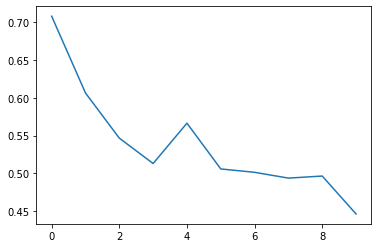

In [112]:
plt.plot(loss)

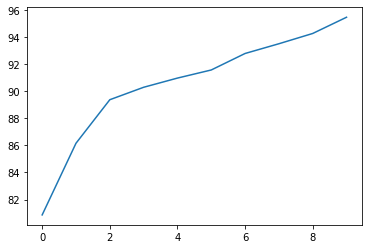

In [113]:
plt.plot(accuracy)

In [114]:
# test data
url = 'https://raw.githubusercontent.com/um-perez-alvaro/Data-Science-Theory/master/Data/digits_test.csv'
data_test = pd.read_csv(url)
data_test.head()

,pixel 0,pixel 1,pixel 2,pixel 3,pixel 4,pixel 5,pixel 6,pixel 7,pixel 8,pixel 9,...,pixel 775,pixel 776,pixel 777,pixel 778,pixel 779,pixel 780,pixel 781,pixel 782,pixel 783,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [115]:
X_test = data_test.drop('label',axis=1).to_numpy()
y_test = data_test['label'].to_numpy()

In [116]:
X_test = X_test.reshape(len(X_test),1,28,28)

In [117]:
i = 1
X_test[i].shape

(1, 28, 28)

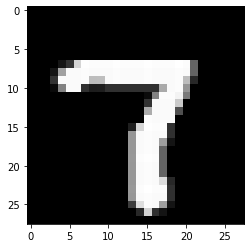

In [118]:
plt.imshow(X_test[i][0],cmap='gray')

In [119]:
layer1.forward(X_test[i])
activation1.forward(layer1.output)

layer2.forward(activation1.output)
activation2.forward(layer2.output)

layer3.forward(activation2.output)

layer4.forward(layer3.output)
activation4.forward(layer4.output)

In [120]:
np.argmax(activation4.output,axis=1)

array([7], dtype=int64)

In [121]:
# predictions
y_test_pred = np.zeros(len(X_test))
for i in range(len(X_test)):

    layer1.forward(X_test[i])
    activation1.forward(layer1.output)

    layer2.forward(activation1.output)
    activation2.forward(layer2.output)

    layer3.forward(activation2.output)

    layer4.forward(layer3.output)
    activation4.forward(layer4.output)
    
    y_test_pred[i] = np.argmax(activation4.output,axis=1)

In [122]:
# accuracy
np.mean(y_test==y_test_pred)

0.8815

## Fashion MNIST

In [137]:
url = 'https://raw.githubusercontent.com/um-perez-alvaro/Data-Science-Theory/master/Data/fashion-mnist_train.csv'
data = pd.read_csv(url)
data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,8,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
1,1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
2,0,0.0,0.0,0.003922,0.0,0.0,0.0,0.0,0.0,0.0,...,0.462745,0.400000,0.40000,0.188235,0.0,0.0,0.003922,0.0,0.0,0.0
3,8,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.003045,0.002876,0.00303,0.002968,0.0,0.0,0.000000,0.0,0.0,0.0
4,0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0


In [138]:
X = data.drop('label',axis=1).to_numpy()
y = data['label'].to_numpy()

In [139]:
X.shape

(5000, 784)

In [140]:
X = X.reshape(len(X),1,28,28)

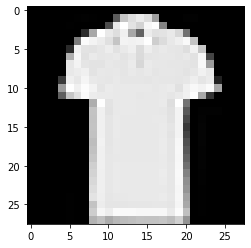

In [143]:
plt.imshow(X[10][0],cmap='gray')

In [141]:
np.bincount(y)

array([480, 507, 434, 523, 505, 514, 519, 506, 495, 517], dtype=int64)

In [144]:
# layer 1
layer1 = convolutional_layer(input_shape=(1,28,28), kernel_size=5, depth=10)
activation1 = ReLU()

# layer 2
layer2 = convolutional_layer(input_shape=(10,24,24), kernel_size=5, depth=10) # 24 = 28-5+1
activation2 = ReLU()

# layer 3
layer3 = reshape(input_shape=(10,20,20), output_shape=(1,10*20*20)) # 20 = 24-5+1

# layer 4
layer4 = layer(n_inputs = 10 * 20 * 20, n_neurons = 10)
activation4 = softmax()


# loss function 
loss_function = loss_crossentropy()

# optimizer
optimizer = optimizer_ADAM(learning_rate=0.1)

In [145]:
# warning: CNNs on CPUs are very slow. To speed it up, we need to run this on GPUs (invented for video games!)
n_epochs = 10
loss = np.zeros(n_epochs)
accuracy = np.zeros(n_epochs)
# gradient descent iterations
for epoch in range(n_epochs):
    
    # EPOCH = loop over all datapoints
    losses = np.zeros(len(X))
    y_pred = np.zeros(len(X))
    for i in range(len(X)):

        # forward pass
        layer1.forward(X[i])
        activation1.forward(layer1.output)

        layer2.forward(activation1.output)
        activation2.forward(layer2.output)
        
        layer3.forward(activation2.output)
        
        layer4.forward(layer3.output)
        activation4.forward(layer4.output)
        

        # sample loss
        losses[i] = loss_function.forward(activation4.output,y[i].reshape(1))
        # prediction
        y_pred[i] = np.argmax(activation4.output,axis=1)
        

        # backward pass
        loss_function.backward(activation4.output,y[i].reshape(1))
        activation4.backward(loss_function.dinputs)
        layer4.backward(activation4.dinputs)

        layer3.backward(layer4.dinputs)
        
        activation2.backward(layer3.dinputs)
        layer2.backward(activation2.dinputs)

        activation1.backward(layer2.dinputs)
        layer1.backward(activation1.dinputs)


        # update weights and biases
        optimizer.pre_update_parameters()
        optimizer.update_parameters(layer1)
        optimizer.update_parameters(layer2)
        optimizer.update_parameters(layer4)
        optimizer.post_update_parameters()

    # loss and accuracy
    loss[epoch] = np.mean(losses)
    accuracy[epoch] = 100*np.mean(y_pred == y)
    
    
    # print loss and accuracy 
    print('epoch: '+str(epoch))
    print('loss: '+str(np.round(loss[epoch],3)))
    print('accuracy: '+str(accuracy[epoch]))
    print('------------------------')

epoch: 0
loss: 2.394
accuracy: 9.94
------------------------
epoch: 1
loss: 2.378
accuracy: 10.0
------------------------
epoch: 2
loss: 2.378
accuracy: 10.0
------------------------
epoch: 3
loss: 2.378
accuracy: 10.0
------------------------
epoch: 4
loss: 2.378
accuracy: 10.0
------------------------
epoch: 5
loss: 2.378
accuracy: 10.0
------------------------
epoch: 6
loss: 2.378
accuracy: 10.0
------------------------
epoch: 7
loss: 2.378
accuracy: 10.0
------------------------
epoch: 8
loss: 2.378
accuracy: 10.0
------------------------
epoch: 9
loss: 2.378
accuracy: 10.0
------------------------


In [ ]:
plt.plot(loss)

In [ ]:
plt.plot(accuracy)